# Modello di classificazione per la predizione dell'abitudine al fumo
In questo notebook viene presentato un modello di classificazione per la predizione dell'abitudine al fumo. Il dataset utilizzato è stato preso dal sito della World Health organization ([WHO](https://www.who.int/teams/noncommunicable-diseases/surveillance/systems-tools/global-youth-tobacco-survey)) e contiene informazioni riguardanti l'abitudine al fumo di 18344 studenti. Il dataset è stato pulito e preprocessato in modo da poter essere utilizzato per l'addestramento di un modello di classificazione. Il modello di classificazione utilizzato è un voting classifier composto da tre modelli di classificazione: LightGBM, ExtraTrees e Random Forest.

### Importazione delle librerie necessarie

In [1]:
import sys
import os

# Set the working directory
sys.path.append(os.getcwd() + os.sep + ".." + os.sep + "..")

# Import the necessary libraries
import pycaret.classification as pc
import pandas as pd
import src.scripts.mapping_answers_dict as map_dict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from math import sqrt

## Caricamento del dataset
Il dataset è stato caricato in un dataframe pandas, è stato assegnato un tipo alle variabili categoriche e numeriche e sono state visualizzate le prime righe del dataframe.

In [2]:
import re

# Load the merged dataset
dataset = pd.read_csv("../../data/processed/GYTS_dataset.csv")

ordinal_columns = ["SmokingFriends", "SeenSmokerInPublicPlace", "SeenSmokerInEnclosedPlace", "SeenSmokerInHome", "HarmfulPassiveSmoke", "HardQuitSmoke"]
dataset[ordinal_columns] = dataset[ordinal_columns].astype('category')

# Convert categorical columns
categorical_columns = ["State", "Gender", "Age", "AttractiveSmoker", "SmokerConfidentInCelebrations", "SchoolWarnings",
                       "SeenHealthWarnings", "AntiTobaccoInEvents"]
dataset[categorical_columns] = dataset[categorical_columns].astype('category')
# remove non letter, non number, non space characters from the categorical columns with regex

dataset[categorical_columns] = dataset[categorical_columns].applymap(lambda x: re.sub(r'[^\w\s\d]', '', x))


# Convert boolean columns to int
boolean_columns = ["Smoke", "SeenSmokerInSchool", "ParentWarnings", "AntiTobaccoInMedia",
                   "BanTobaccoOutdoors", "SmokingFather", "SmokingMother", "WorkingFather",
                   "WorkingMother"]
dataset[boolean_columns] = dataset[boolean_columns].astype('int')
dataset.head()

,Age,Gender,Smoke,SmokingFriends,SeenSmokerInSchool,SeenSmokerInPublicPlace,SeenSmokerInEnclosedPlace,SeenSmokerInHome,ParentWarnings,AttractiveSmoker,...,SeenHealthWarnings,AntiTobaccoInEvents,AntiTobaccoInMedia,BanTobaccoOutdoors,HarmfulPassiveSmoke,State,SmokingFather,SmokingMother,WorkingFather,WorkingMother
0,12 years old,Female,1,None of them,0,3 to 4 days,3 to 4 days,0 days,1,More attractive,...,Yes but I didnt think much of them,I did not go to events in the past 30 days,1,1,Probably yes,Portugal,0,0,1,0
1,14 years old,Female,1,Some of them,1,3 to 4 days,3 to 4 days,1 to 2 days,1,Less attractive,...,Yes but I didnt think much of them,I did not go to events in the past 30 days,1,1,Definitely not,Portugal,0,0,1,0
2,14 years old,Female,1,None of them,1,3 to 4 days,3 to 4 days,1 to 2 days,1,More attractive,...,Yes but I didnt think much of them,I did not go to events in the past 30 days,1,1,Probably not,Portugal,0,0,1,1
3,14 years old,Female,1,None of them,0,1 to 2 days,1 to 2 days,1 to 2 days,1,No difference,...,Yes but I didnt think much of them,I did not go to events in the past 30 days,1,1,Definitely not,Portugal,0,0,1,1
4,14 years old,Female,1,None of them,0,3 to 4 days,3 to 4 days,1 to 2 days,1,No difference,...,Yes but I didnt think much of them,I did not go to events in the past 30 days,1,1,Definitely not,Portugal,0,0,1,0


## Setup
Viene settato il setup di pyCaret per il training del modello di classificazione. Vengono passati al setup il dataframe, la variabile target e le variabili categoriche. Viene utilizzato l'80% del dataset per il training e il 20% per il testing. Viene utilizzata la stratified 10-fold cross validation.
Le colonne del dataframe vengono preprocessate in modo da poter essere utilizzate per l'addestramento del modello:
- Le variabili categoriche vengono codificate con l'encoding one-hot.
- Le variabili ordinali vengono codificate con l'encoding ordinale.

In [29]:
from sklearn.preprocessing import OneHotEncoder

ordinal_features = {"SmokingFriends": map_dict.OR46_dict.values(),
                    "SeenSmokerInPublicPlace": map_dict.CR21_dict.values(),
                    "SeenSmokerInEnclosedPlace": map_dict.CR20_dict.values(),
                    "SeenSmokerInHome": map_dict.CR19_dict.values(),
                    "HarmfulPassiveSmoke": map_dict.CR23_dict.values(),
                    "HardQuitSmoke": map_dict.CR41_dict.values()}

setup = pc.setup(data=dataset,
                 target='Smoke',
                 index=False,
                 train_size=0.8,
                 session_id=12,
                 categorical_features=categorical_columns,
                 ordinal_features= ordinal_features,
                 imputation_type=None,
                 max_encoding_ohe=0,
                 encoding_method=OneHotEncoder(dtype=int, sparse_output=False),
                 n_jobs=10
                 )

,Description,Value
0,Session id,12
1,Target,Smoke
2,Target type,Binary
3,Original data shape,"(20731, 23)"
4,Transformed data shape,"(20731, 42)"
5,Transformed train set shape,"(16584, 42)"
6,Transformed test set shape,"(4147, 42)"
7,Ordinal features,6
8,Numeric features,8
9,Categorical features,8


### Calcolo dei pesi delle classi
Viene calcolato il peso delle classi per il bilanciamento del dataset.

In [30]:
classes = dataset['Smoke'].unique()

class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=pc.get_config("y_train_transformed"))
sqrt_weights = [sqrt(weight) for weight in class_weights]

class_weights = dict(zip(classes, class_weights))
sqrt_weights = dict(zip(classes, sqrt_weights))

print("Square rooted class weight:", sqrt_weights)

Square rooted class weight: {1: 1.7447214286057597, 0: 0.7734781175110246}


## Confronto tra i modelli
Vengono confrontati tutti i modelli di classificazione disponibili in pyCaret compatibili con i pesi delle classi. Viene mostrata una tabella con i risultati ottenuti dai modelli.

In [31]:
from IPython.display import display, HTML

# Models that support class weights
weighted_model_id =[ 'lr', 'dt', 'svm' , 'ridge', 'rf', 'et', 'lightgbm'] # 'rbfsvm'
models = {}
predicts = pd.DataFrame()
cv_results = pd.DataFrame()

for model_id in weighted_model_id:
    try:
        # get model name from setup
        model_name = pc.models().loc[model_id].Name
        
        display(HTML(f"<h2>Training {model_name}</h2>"))
        model = pc.create_model(model_id, verbose=True, class_weight=sqrt_weights)
        models[model_id] = model
        
        cv =  pc.pull()
        cv = cv.loc['Mean']
        cv = cv.to_frame().transpose()
        
        cv.index = [model_name] # set index to model name
        cv_results = pd.concat([cv_results, cv])
        
        display(HTML(f"<h3>Predicting {model_name}</h3>"))
        pc.predict_model(model)
        predict = pc.pull()
        predicts = pd.concat([predicts, predict])
    except Exception as e:
        print(e)

# Sort the models by MCC
cv_results = cv_results.sort_values('MCC', ascending=False)
predicts = predicts.sort_values('MCC', ascending=False)

display(HTML(f"<h2>Cross validation mean results</h2>{cv_results.to_html()}"))
display(HTML(f"<h2>Predictions result</h2>{predicts.to_html()}"))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8487,0.0000,0.6044,0.5357,0.5680,0.4767,0.4780
1,0.8439,0.0000,0.5934,0.5226,0.5557,0.4615,0.4629
2,0.8439,0.0000,0.5678,0.5236,0.5448,0.4508,0.4513
3,0.8427,0.0000,0.5824,0.5196,0.5492,0.4543,0.4554
4,0.8492,0.0000,0.5735,0.5379,0.5552,0.4645,0.4648
5,0.8559,0.0000,0.5515,0.5618,0.5566,0.4705,0.4706
6,0.8275,0.0000,0.5441,0.4774,0.5086,0.4045,0.4058
7,0.8504,0.0000,0.6103,0.5390,0.5724,0.4822,0.4836
8,0.8384,0.0000,0.5625,0.5066,0.5331,0.4357,0.4366


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8433,0.8413,0.5668,0.5209,0.5429,0.4485,0.4491


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8222,0.0000,0.4908,0.4621,0.4760,0.3691,0.3693
1,0.8198,0.0000,0.4579,0.4529,0.4554,0.3474,0.3474
2,0.8174,0.0000,0.4652,0.4472,0.4560,0.3463,0.3464
3,0.8222,0.0000,0.4689,0.4604,0.4646,0.3580,0.3580
4,0.8221,0.0000,0.4779,0.4594,0.4685,0.3617,0.3618
5,0.8281,0.0000,0.4118,0.4726,0.4401,0.3391,0.3402
6,0.7961,0.0000,0.4118,0.3862,0.3986,0.2760,0.2762
7,0.8130,0.0000,0.4669,0.4349,0.4504,0.3379,0.3382
8,0.8197,0.0000,0.4779,0.4530,0.4651,0.3568,0.3569


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8119,0.6586,0.4302,0.4277,0.4290,0.3164,0.3164


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8445,0.0000,0.6007,0.5240,0.5597,0.4658,0.4674
1,0.8469,0.0000,0.4066,0.5468,0.4664,0.3793,0.3849
2,0.8421,0.0000,0.5531,0.5189,0.5355,0.4404,0.4408
3,0.8240,0.0000,0.6960,0.4762,0.5655,0.4599,0.4730
4,0.8546,0.0000,0.4044,0.5820,0.4772,0.3960,0.4048
5,0.8432,0.0000,0.5625,0.5204,0.5406,0.4463,0.4468
6,0.8257,0.0000,0.5037,0.4708,0.4867,0.3818,0.3822
7,0.8185,0.0000,0.7169,0.4654,0.5644,0.4562,0.4732
8,0.8468,0.0000,0.4449,0.5402,0.4879,0.3988,0.4014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8544,0.6999,0.4699,0.5684,0.5145,0.4297,0.4324


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8535,0.0000,0.5971,0.5507,0.5729,0.4847,0.4853
1,0.8445,0.0000,0.5788,0.5249,0.5505,0.4568,0.4576
2,0.8475,0.0000,0.5604,0.5350,0.5474,0.4558,0.4559
3,0.8457,0.0000,0.5678,0.5290,0.5477,0.4548,0.4552
4,0.8522,0.0000,0.5625,0.5484,0.5554,0.4668,0.4668
5,0.8571,0.0000,0.5294,0.5692,0.5486,0.4638,0.4642
6,0.8287,0.0000,0.5221,0.4797,0.5000,0.3969,0.3974
7,0.8546,0.0000,0.6066,0.5518,0.5779,0.4904,0.4912
8,0.8402,0.0000,0.5294,0.5125,0.5208,0.4249,0.4250


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8442,0.7245,0.5463,0.5247,0.5353,0.4417,0.4419


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8831,0.0000,0.3736,0.8160,0.5126,0.4564,0.5015
1,0.8813,0.0000,0.3736,0.7969,0.5087,0.4511,0.4931
2,0.8734,0.0000,0.3370,0.7603,0.4670,0.4071,0.4507
3,0.8819,0.0000,0.3590,0.8235,0.5000,0.4445,0.4940
4,0.8733,0.0000,0.3235,0.7719,0.4560,0.3976,0.4460
5,0.8752,0.0000,0.3088,0.8155,0.4480,0.3933,0.4528
6,0.8595,0.0000,0.3051,0.6535,0.4160,0.3479,0.3807
7,0.8848,0.0000,0.3824,0.8189,0.5213,0.4655,0.5093
8,0.8739,0.0000,0.3529,0.7442,0.4788,0.4173,0.4550


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8751,0.8588,0.3568,0.7523,0.4841,0.4231,0.4614


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8788,0.0000,0.3626,0.7857,0.4962,0.4378,0.4803
1,0.8843,0.0000,0.3700,0.8347,0.5127,0.4579,0.5070
2,0.8734,0.0000,0.3443,0.7520,0.4724,0.4115,0.4523
3,0.8813,0.0000,0.3773,0.7923,0.5112,0.4531,0.4937
4,0.8685,0.0000,0.3162,0.7288,0.4410,0.3794,0.4221
5,0.8715,0.0000,0.2978,0.7864,0.4320,0.3757,0.4325
6,0.8619,0.0000,0.3235,0.6617,0.4346,0.3663,0.3968
7,0.8806,0.0000,0.3603,0.8033,0.4975,0.4406,0.4865
8,0.8715,0.0000,0.3603,0.7153,0.4792,0.4149,0.4468


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8744,0.8533,0.3524,0.7500,0.4795,0.4185,0.4572


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8547,0.0000,0.6081,0.5533,0.5794,0.4918,0.4926
1,0.8602,0.0000,0.5751,0.5751,0.5751,0.4914,0.4914
2,0.8565,0.0000,0.5861,0.5614,0.5735,0.4873,0.4875
3,0.8620,0.0000,0.6154,0.5753,0.5947,0.5116,0.5120
4,0.8673,0.0000,0.6250,0.5903,0.6071,0.5274,0.5277
5,0.8697,0.0000,0.5772,0.6085,0.5925,0.5150,0.5152
6,0.8468,0.0000,0.5515,0.5319,0.5415,0.4496,0.4497
7,0.8733,0.0000,0.6397,0.6084,0.6237,0.5476,0.5478
8,0.8589,0.0000,0.6103,0.5646,0.5866,0.5016,0.5022


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8621,0.8580,0.6035,0.5764,0.5897,0.5068,0.5070


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Light Gradient Boosting Machine,0.8611,0.0,0.5984,0.5745,0.5860,0.5026,0.5029
Random Forest Classifier,0.8759,0.0,0.3454,0.7749,0.4774,0.4186,0.4630
Logistic Regression,0.8454,0.0,0.5793,0.5273,0.5518,0.4587,0.4596
Ridge Classifier,0.8477,0.0,0.5635,0.5352,0.5487,0.4572,0.4576
Extra Trees Classifier,0.8746,0.0,0.3469,0.7606,0.4759,0.4159,0.4576
SVM - Linear Kernel,0.8415,0.0,0.5301,0.5307,0.5192,0.4262,0.4328
Decision Tree Classifier,0.8173,0.0,0.4585,0.4461,0.4518,0.3423,0.3426


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8621,0.8580,0.6035,0.5764,0.5897,0.5068,0.5070
0,Random Forest Classifier,0.8751,0.8588,0.3568,0.7523,0.4841,0.4231,0.4614
0,Extra Trees Classifier,0.8744,0.8533,0.3524,0.7500,0.4795,0.4185,0.4572
0,Logistic Regression,0.8433,0.8413,0.5668,0.5209,0.5429,0.4485,0.4491
0,Ridge Classifier,0.8442,0.7245,0.5463,0.5247,0.5353,0.4417,0.4419
0,SVM - Linear Kernel,0.8544,0.6999,0.4699,0.5684,0.5145,0.4297,0.4324
0,Decision Tree Classifier,0.8119,0.6586,0.4302,0.4277,0.4290,0.3164,0.3164


### Modello 1: Light Gradient Boosting Machine
Il primo modello che viene allenato è il Light Gradient Boosting Machine (LGBM), che era il primo modello per accuracy nella confronto tra modelli.

In [32]:
lgbm_model = models['lightgbm']

display(HTML(f"<h2>Tuning LightGBM model</h2>"))
lgbm_tuned_model = pc.tune_model(lgbm_model, search_library='scikit-optimize', search_algorithm='bayesian', optimize='MCC')
display(HTML(f"<h2>Ensemble LightGBM model</h2>"))
lgbm_ensemble_model = pc.ensemble_model(lgbm_tuned_model, method='Bagging', optimize='MCC')

display(HTML(f"<h3>Predicting LightGBM model on test data</h3>"))
display(HTML(f"<h4>Predicting base model</h4>"))
pc.predict_model(lgbm_model)
display(HTML(f"<h4>Predicting tuned model</h4>"))
pc.predict_model(lgbm_tuned_model)
display(HTML(f"<h4>Predicting ensemble model</h4>"))
_ = pc.predict_model(lgbm_ensemble_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8668,0.0000,0.5568,0.6032,0.5790,0.5001,0.5006
1,0.8662,0.0000,0.5348,0.6058,0.5681,0.4893,0.4906
2,0.8650,0.0000,0.5238,0.6034,0.5608,0.4815,0.4832
3,0.8686,0.0000,0.5641,0.6087,0.5856,0.5076,0.5081
4,0.8697,0.0000,0.5221,0.6228,0.5680,0.4920,0.4946
5,0.8806,0.0000,0.5074,0.6832,0.5823,0.5144,0.5221
6,0.8613,0.0000,0.5147,0.5882,0.5490,0.4675,0.4689
7,0.8721,0.0000,0.5588,0.6230,0.5891,0.5137,0.5148
8,0.8649,0.0000,0.5368,0.5984,0.5659,0.4862,0.4872


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8674,0.0000,0.5824,0.6000,0.5911,0.5120,0.5120
1,0.8698,0.0000,0.5678,0.6126,0.5894,0.5121,0.5126
2,0.8608,0.0000,0.5531,0.5808,0.5666,0.4837,0.4839
3,0.8692,0.0000,0.6081,0.6014,0.6047,0.5264,0.5264
4,0.8770,0.0000,0.5919,0.6339,0.6122,0.5392,0.5396
5,0.8758,0.0000,0.5368,0.6460,0.5863,0.5140,0.5170
6,0.8528,0.0000,0.5625,0.5504,0.5564,0.4682,0.4682
7,0.8758,0.0000,0.5993,0.6269,0.6128,0.5388,0.5390
8,0.8631,0.0000,0.5809,0.5830,0.5820,0.5001,0.5001


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8621,0.8580,0.6035,0.5764,0.5897,0.5068,0.5070


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8621,0.8580,0.6035,0.5764,0.5897,0.5068,0.5070


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8676,0.8612,0.5859,0.5991,0.5924,0.5134,0.5135


### Modello 2: Extra Trees Classifier
Il secondo modello che viene allenato è l'Extra Trees Classifier, che era il secondo modello per accuracy nella confronto tra modelli.

In [34]:
et_model = models['et']
display(HTML(f"<h2>Tuning Extra Trees model</h2>"))
et_tuned_model = pc.tune_model(et_model, search_library='scikit-optimize', search_algorithm='bayesian', optimize='MCC')
display(HTML(f"<h2>Ensemble Extra Trees model</h2>"))
et_ensemble_model = pc.ensemble_model(et_tuned_model, method='Boosting', optimize='MCC')

display(HTML(f"<h3>Predicting Extra Trees model on test data</h3>"))
display(HTML(f"<h4>Predicting base model</h4>"))
pc.predict_model(et_model)
display(HTML(f"<h4>Predicting tuned model</h4>"))
pc.predict_model(et_tuned_model)
display(HTML(f"<h4>Predicting ensemble model</h4>"))
_ = pc.predict_model(et_ensemble_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8246,0.0000,0.6850,0.4770,0.5624,0.4571,0.4688
1,0.8324,0.0000,0.6447,0.4930,0.5587,0.4576,0.4638
2,0.8222,0.0000,0.6484,0.4707,0.5455,0.4384,0.4470
3,0.8366,0.0000,0.6996,0.5026,0.5850,0.4867,0.4970
4,0.8359,0.0000,0.6397,0.5000,0.5613,0.4623,0.4676
5,0.8432,0.0000,0.6507,0.5175,0.5765,0.4819,0.4866
6,0.8118,0.0000,0.6324,0.4479,0.5244,0.4113,0.4208
7,0.8311,0.0000,0.6838,0.4895,0.5706,0.4690,0.4792
8,0.8293,0.0000,0.6765,0.4855,0.5653,0.4626,0.4725


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8638,0.0000,0.5788,0.5874,0.5830,0.5016,0.5016
1,0.8668,0.0000,0.5678,0.6008,0.5838,0.5046,0.5049
2,0.8650,0.0000,0.5495,0.5976,0.5725,0.4925,0.4931
3,0.8740,0.0000,0.6044,0.6203,0.6122,0.5371,0.5371
4,0.8552,0.0000,0.5551,0.5593,0.5572,0.4707,0.4707
5,0.8745,0.0000,0.5404,0.6391,0.5857,0.5124,0.5149
6,0.8456,0.0000,0.5515,0.5282,0.5396,0.4469,0.4470
7,0.8673,0.0000,0.5699,0.6008,0.5849,0.5060,0.5063
8,0.8649,0.0000,0.5735,0.5909,0.5821,0.5015,0.5016


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8744,0.8533,0.3524,0.7500,0.4795,0.4185,0.4572


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8191,0.8455,0.6490,0.4638,0.5410,0.4323,0.4417


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8585,0.8458,0.5698,0.5689,0.5693,0.4846,0.4846


### Modello 3: Random Forest Classifier
Il terzo modello che viene allenato è il Random Forest Classifier, che era il terzo modello per accuracy nella confronto tra modelli.

In [19]:
rf_model = models['rf']
display(HTML(f"<h2>Tuning Random Forest model</h2>"))
rf_tuned_model = pc.tune_model(rf_model, search_library='scikit-optimize', search_algorithm='bayesian', optimize='MCC')
display(HTML(f"<h2>Ensemble Random Forest model</h2>"))
rf_ensemble_model = pc.ensemble_model(rf_tuned_model, method='Boosting', optimize='MCC')

display(HTML(f"<h3>Predicting Random Forest model on test data</h3>"))
display(HTML(f"<h4>Predicting base model</h4>"))
pc.predict_model(rf_model)
display(HTML(f"<h4>Predicting tuned model</h4>"))
pc.predict_model(rf_tuned_model)
display(HTML(f"<h4>Predicting ensemble model</h4>"))
_ = pc.predict_model(rf_ensemble_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8246,0.0000,0.7033,0.4776,0.5689,0.4638,0.4775
1,0.8306,0.0000,0.6300,0.4886,0.5504,0.4481,0.4536
2,0.8264,0.0000,0.6520,0.4798,0.5528,0.4482,0.4563
3,0.8354,0.0000,0.6667,0.5000,0.5714,0.4722,0.4796
4,0.8293,0.0000,0.6471,0.4848,0.5543,0.4514,0.4586
5,0.8396,0.0000,0.6507,0.5086,0.5710,0.4741,0.4796
6,0.8172,0.0000,0.6434,0.4593,0.5360,0.4261,0.4355
7,0.8317,0.0000,0.6765,0.4907,0.5688,0.4675,0.4768
8,0.8263,0.0000,0.6691,0.4789,0.5583,0.4538,0.4637


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8638,0.0000,0.5714,0.5887,0.5799,0.4987,0.4987
1,0.8632,0.0000,0.5788,0.5852,0.5820,0.5002,0.5002
2,0.8650,0.0000,0.5604,0.5953,0.5774,0.4971,0.4974
3,0.8650,0.0000,0.5861,0.5904,0.5882,0.5075,0.5075
4,0.8613,0.0000,0.5404,0.5833,0.5611,0.4788,0.4793
5,0.8721,0.0000,0.5294,0.6316,0.5760,0.5014,0.5041
6,0.8450,0.0000,0.5515,0.5263,0.5386,0.4455,0.4457
7,0.8619,0.0000,0.5772,0.5793,0.5783,0.4957,0.4957
8,0.8643,0.0000,0.5735,0.5887,0.5810,0.5001,0.5001


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8751,0.8588,0.3568,0.7523,0.4841,0.4231,0.4614


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8228,0.8417,0.6358,0.4707,0.5409,0.4341,0.4417


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8592,0.8441,0.5580,0.5732,0.5655,0.4815,0.4815


## Blending dei modelli
Vengono effettuati due test di blending dei modelli:
- blending dei primi due modelli
- blending di tutti e tre i modelli

### Blend 1: LGBM + Extra Trees

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8686,0.0000,0.5788,0.6054,0.5918,0.5135,0.5137
1,0.8716,0.0000,0.5641,0.6210,0.5912,0.5152,0.5161
2,0.8656,0.0000,0.5568,0.5984,0.5769,0.4971,0.4975
3,0.8734,0.0000,0.6081,0.6171,0.6125,0.5369,0.5369
4,0.8770,0.0000,0.5882,0.6349,0.6107,0.5377,0.5383
5,0.8770,0.0000,0.5404,0.6504,0.5904,0.5187,0.5218
6,0.8522,0.0000,0.5625,0.5484,0.5554,0.4668,0.4668
7,0.8764,0.0000,0.5956,0.6304,0.6125,0.5390,0.5393
8,0.8601,0.0000,0.5551,0.5763,0.5655,0.4822,0.4823


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8693,0.8585,0.5830,0.6061,0.5943,0.5165,0.5166


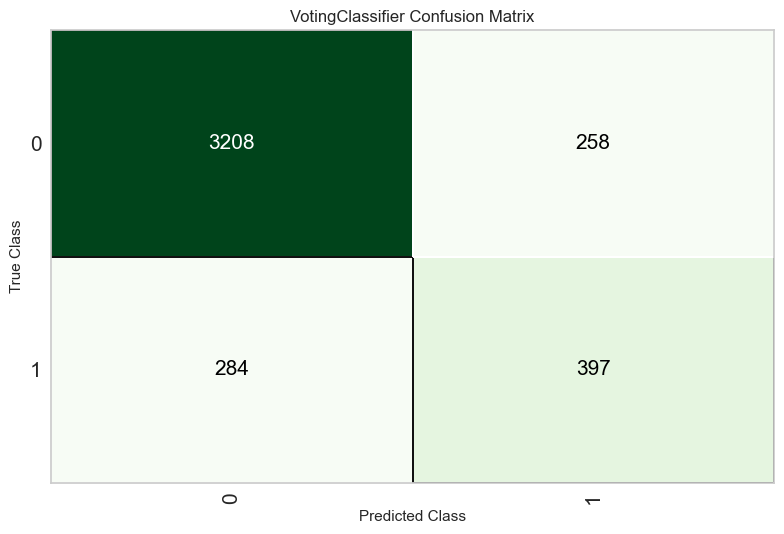

In [35]:
display(HTML(f"<h2>Blending models</h2>"))
blended_model = pc.blend_models(estimator_list=[lgbm_ensemble_model, et_ensemble_model], method='soft', optimize='MCC') 

display(HTML(f"<h3>Predicting blended model on test data</h3>"))
pc.predict_model(blended_model)

pc.plot_model(blended_model, plot='confusion_matrix')

In [35]:
from src.scripts.custom_functions import custom_optimize_threshold

threshold_blended_model = custom_optimize_threshold(pc, blended_model, optimize='MCC')

Threshold: 0.625. MCC: 0.4814
Threshold: 0.515625. MCC: 0.5106
Threshold: 0.90625. MCC: 0.0676
Threshold: 0.796875. MCC: 0.2735
Threshold: 0.6875. MCC: 0.431
Threshold: 0.75. MCC: 0.3513
Threshold: 0.578125. MCC: 0.5057
Threshold: 0.46875. MCC: 0.5108
Threshold: 0.96875. MCC: 0.0
Threshold: 0.859375. MCC: 0.1753
Threshold: 0.375. MCC: 0.4827
Threshold: 0.390625. MCC: 0.4905
Threshold: 0.40625. MCC: 0.4945
Threshold: 0.421875. MCC: 0.5031
Threshold: 0.15625. MCC: 0.1563
Threshold: 0.171875. MCC: 0.193
Threshold: 0.1875. MCC: 0.2361
Threshold: 0.203125. MCC: 0.2763
Threshold: 0.21875. MCC: 0.3093
Threshold: 0.28125. MCC: 0.4143
Threshold: 0.265625. MCC: 0.3923
Threshold: 0.0. MCC: 0.0
Threshold: 0.234375. MCC: 0.3391
Threshold: 0.296875. MCC: 0.4293
Threshold: 0.3125. MCC: 0.4433
Threshold: 0.328125. MCC: 0.457
Threshold: 0.34375. MCC: 0.4632
Threshold: 0.359375. MCC: 0.4696
Threshold: 0.53125. MCC: 0.5098
Threshold: 0.640625. MCC: 0.4733
Threshold: 0.8125. MCC: 0.2519
Threshold: 0.92187

### Blend 2: LGBM + Extra Trees + Random Forest

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8686,0.0000,0.5788,0.6054,0.5918,0.5135,0.5137
1,0.8710,0.0000,0.5641,0.6185,0.5900,0.5137,0.5145
2,0.8668,0.0000,0.5531,0.6040,0.5774,0.4985,0.4992
3,0.8740,0.0000,0.6117,0.6185,0.6151,0.5398,0.5398
4,0.8715,0.0000,0.5662,0.6185,0.5912,0.5151,0.5158
5,0.8770,0.0000,0.5331,0.6532,0.5870,0.5156,0.5193
6,0.8516,0.0000,0.5478,0.5478,0.5478,0.4590,0.4590
7,0.8770,0.0000,0.5919,0.6339,0.6122,0.5392,0.5396
8,0.8595,0.0000,0.5551,0.5741,0.5645,0.4807,0.4808


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8669,0.8565,0.5786,0.5979,0.5881,0.5087,0.5088


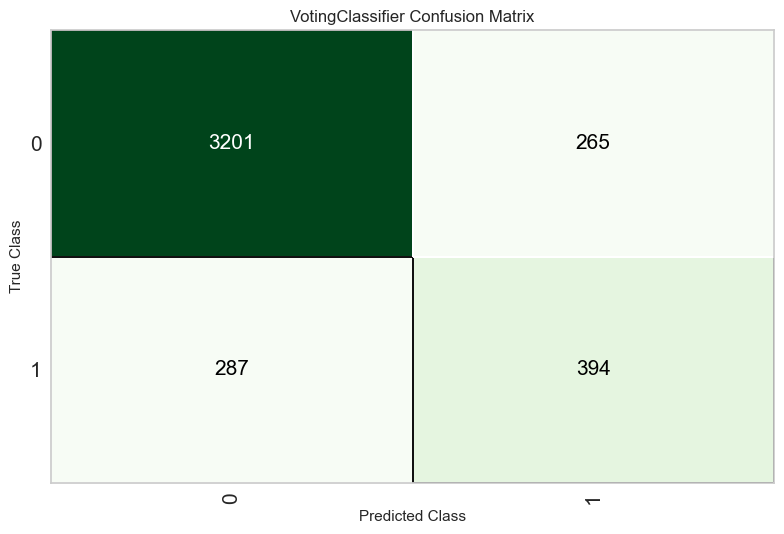

In [23]:
display(HTML(f"<h2>Blending models</h2>"))
blended_model2 = pc.blend_models(estimator_list=[lgbm_ensemble_model, et_ensemble_model, rf_ensemble_model], method='soft') 

display(HTML(f"<h3>Predicting blended model on test data</h3>"))
pc.predict_model(blended_model2)

pc.plot_model(blended_model2, plot='confusion_matrix')

## Risultati
Dai risultati ottenuti dai test di blending, il modello migliore è il blend dei primi due modelli modelli. Questo modello verrà utilizzato per la predizione dell'abitudine al fumo.

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:46:51
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8686,0.0000,0.5788,0.6054,0.5918,0.5135,0.5137
1,0.8716,0.0000,0.5641,0.6210,0.5912,0.5152,0.5161
2,0.8656,0.0000,0.5568,0.5984,0.5769,0.4971,0.4975
3,0.8734,0.0000,0.6081,0.6171,0.6125,0.5369,0.5369
4,0.8770,0.0000,0.5882,0.6349,0.6107,0.5377,0.5383
5,0.8770,0.0000,0.5404,0.6504,0.5904,0.5187,0.5218
6,0.8522,0.0000,0.5625,0.5484,0.5554,0.4668,0.4668
7,0.8764,0.0000,0.5956,0.6304,0.6125,0.5390,0.5393
8,0.8601,0.0000,0.5551,0.5763,0.5655,0.4822,0.4823


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8686,0.8585,0.5800,0.6040,0.5918,0.5135,0.5136


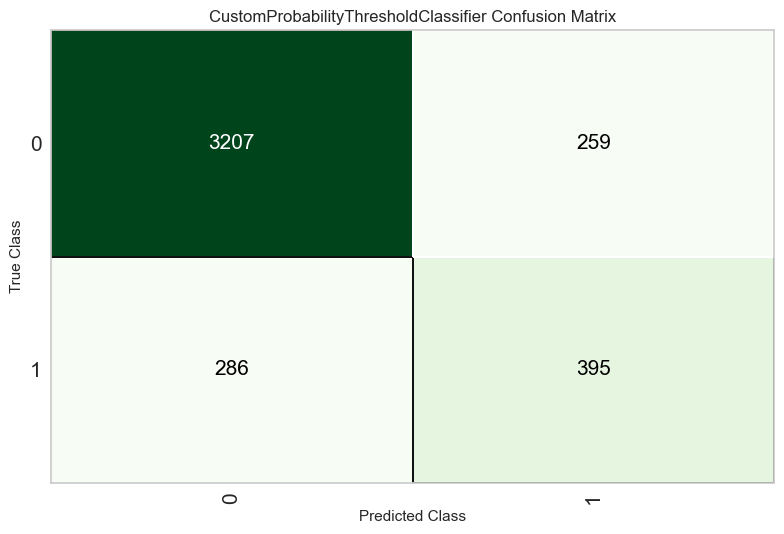

In [37]:
display(HTML(f"<h2>Final model</h2>"))
final_model = pc.create_model(blended_model, probability_threshold=0.50)
 
display(HTML(f"<h3>Final model on test data</h3>"))
pc.predict_model(final_model)

pc.plot_model(final_model, plot='confusion_matrix')

# Salvataggio del modello su file
Il modello viene salvato su file per poter essere utilizzato in futuro senza doverlo riallenare.

In [ ]:
pc.save_model(final_model, "../../data/models/final_model")

## Dashboard
È stata creata una dashboard per visualizzare i risultati ottenuti dal modello di classificazione.

In [ ]:

from src.scripts.custom_functions import custom_dashboard

explainer_dashboard = custom_dashboard(pc, estimator=final_model, 
                                       categorical_columns=categorical_columns, 
                                       display_format='external', 
                                       sample_dimension=4147,
                                       shap='kernel', 
                                       dashboard_kwargs={"port": 8100})

Exporting to yaml file the dashboard

In [ ]:
explainer_dashboard.to_yaml("../../data/models/dashboard_config2.yaml", dump_explainer=True, explainerfile="final_model_explainer2.dill")

# Importazione del modello
Siccome l'addestramento del modello richiede molto tempo e risorse, il modello è stato salvato in un file .pkl e verrà importato in questa sezione del notebook, per poi essere utilizzato per fare predizioni sul dataset di test. Inoltre può essere importata la dashboard per visualizzare i risultati ottenuti.

In [ ]:
final_model = pc.load_model("../../data/models/final_model")
pc.evaluate_model(final_model)
pc.predict_model(final_model)

In [33]:
from explainerdashboard import ExplainerDashboard
explainer_dashboard2 = ExplainerDashboard.from_config("../../data/models/final_model_explainer.dill", "../../data/models/dashboard_config.yaml",)
explainer_dashboard2.run(port=5502)

Building ExplainerDashboard..
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.188.168:5502
You can terminate the dashboard with ExplainerDashboard.terminate(5502)


Dash app running on http://127.0.0.1:5502/
